# Data engineering and firsts DL steps 

In [1]:
from csv import writer
import pickle
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import os
import imageio.v2 as imageio
from PIL import Image

In [2]:
df = pd.read_csv('./insects.csv')

In [3]:
df

,sample,species,filename
0,003311_1,Andrena fulva,2_003311_1_2020_05_09-14-21-01-959.jpg
1,003311_1,Andrena fulva,2_003311_1_2020_05_09-14-21-01-929.jpg
2,003311_1,Andrena fulva,2_003311_1_2020_05_09-14-21-01-608.jpg
3,003311_1,Andrena fulva,1_003311_1_2020_05_09-14-21-02-531.jpg
4,003311_1,Andrena fulva,1_003311_1_2020_05_09-14-21-02-266.jpg
...,...,...,...
719,208261_1,Lasioglossum punctatissimum,1_208261_1_2020_03_06-14-53-53-592.jpg
720,208261_1,Lasioglossum punctatissimum,1_208261_1_2020_03_06-14-53-53-670.jpg
721,208261_1,Lasioglossum punctatissimum,2_208261_1_2020_03_06-14-53-53-447.jpg
722,208261_1,Lasioglossum punctatissimum,1_208261_1_2020_03_06-14-53-53-643.jpg


In [4]:
df = df.drop(['sample'], axis='columns') 
df

,species,filename
0,Andrena fulva,2_003311_1_2020_05_09-14-21-01-959.jpg
1,Andrena fulva,2_003311_1_2020_05_09-14-21-01-929.jpg
2,Andrena fulva,2_003311_1_2020_05_09-14-21-01-608.jpg
3,Andrena fulva,1_003311_1_2020_05_09-14-21-02-531.jpg
4,Andrena fulva,1_003311_1_2020_05_09-14-21-02-266.jpg
...,...,...
719,Lasioglossum punctatissimum,1_208261_1_2020_03_06-14-53-53-592.jpg
720,Lasioglossum punctatissimum,1_208261_1_2020_03_06-14-53-53-670.jpg
721,Lasioglossum punctatissimum,2_208261_1_2020_03_06-14-53-53-447.jpg
722,Lasioglossum punctatissimum,1_208261_1_2020_03_06-14-53-53-643.jpg


In this phase the data is examined and dropped the "sample" column as instruction

In [5]:
data_folder= "Insects"
path= "./Insects/"
listing = os.listdir(path)
hmin= 0
wmin= 0
for file in listing:
    im = Image.open(path + file)
    width, height = im.size
    if hmin== 0 or hmin> height:
        hmin= height
    if wmin== 0 or wmin> height:
        wmin= width

print (hmin)
print (wmin)

520
520


The size of the images is analyzed. Given some slightly difference between some images, the iterator has to produce tensor of input of the same size: the size selected is the smallest size of the entire image collection.

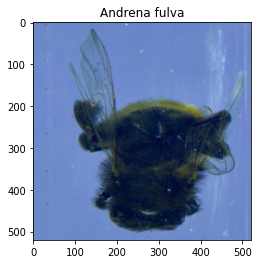

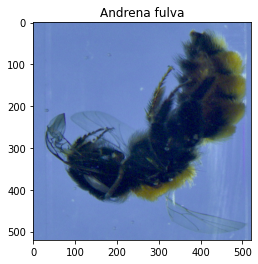

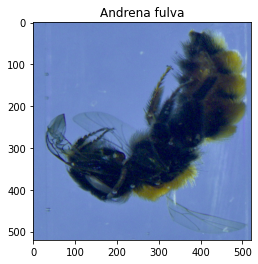

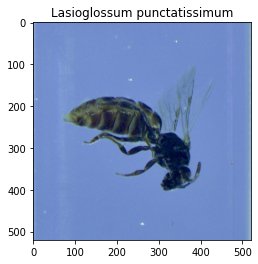

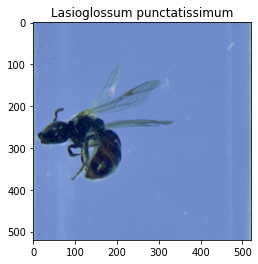

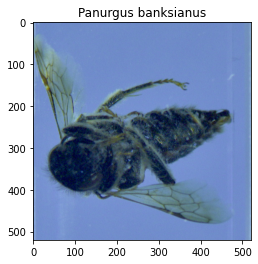

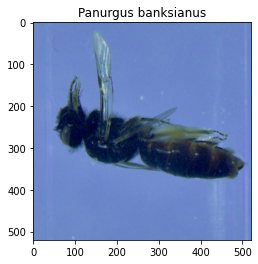

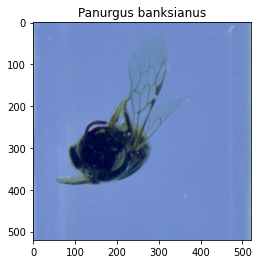

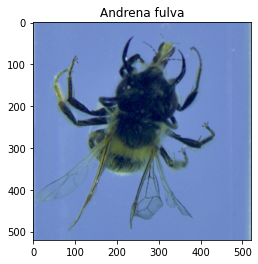

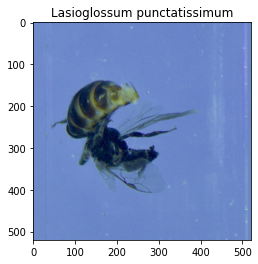

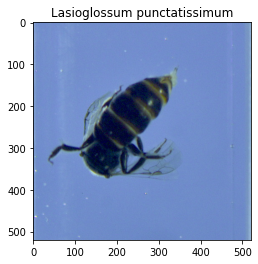

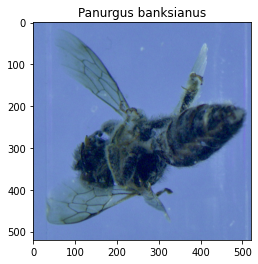

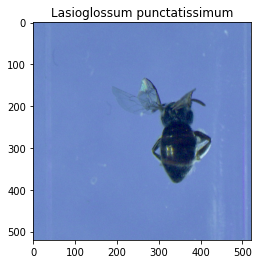

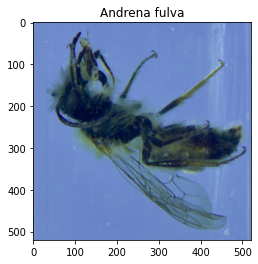

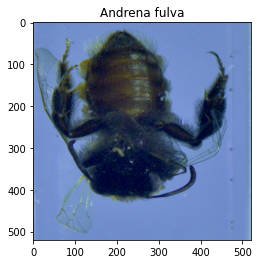

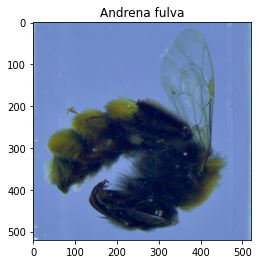

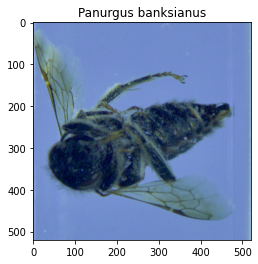

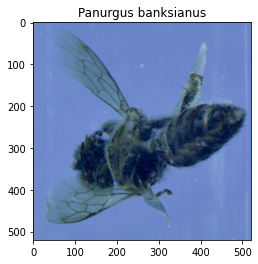

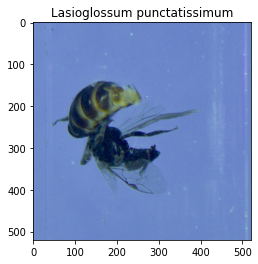

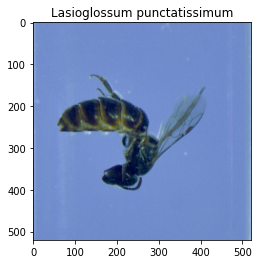

In [6]:
batch_size = 4
data_folder= "Insects"

transform = transforms.Compose(([transforms.ToTensor(),
                              transforms.Resize((hmin,wmin))]))

class BeesData(Dataset):
    def __init__(self, path, transform= None, target_transform= None):
        # read the date from the file     
        self.df = pd.read_csv('./insects.csv')
        self.df = self.df.drop(['sample'], axis='columns')
        self.img_dir = path
        self.transform = transform
        self.target_transform = target_transform
        
        # label string to int converter        
        
        # self.c2i = {}
        # self.categories = sorted(self.df['species'].unique())
        # for i, category in enumerate(self.categories):
        #     self.c2i[category] = i
        # self.df.species = [self.c2i[item] for item in self.df.species]
        
        img_path = os.path.join(self.img_dir, self.df.iloc[0, 1])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        #read the image from the assigned self.img_dir path
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 1])
        image = imageio.imread(img_path).astype(np.float32)
        label = self.df.iloc[idx, 0]
        if self.transform:
            # transform the image as indicated from transforms.Compose()
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label          

dataset = BeesData(data_folder, transform)

# Set up the dataset.
trainloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True)

# get some images
dataiter = iter(trainloader)
images, labels = dataiter.next()


for i in range(5): #Run through 5 bathes
    images, labels = dataiter.next()
    for image, label in zip(images,labels): # Run through all samples in a batch
        plt.figure()
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)).astype('uint32'))
        plt.title(str(label))

A personalized Dataset-class is created, read the data from "insects.csv" file, deleting the "sample" column and with given directives as argument, we have an output a tensor of "hmin" and "lmin" that represent an image and the label associated. A commented out code part inside the Dataset-class it can be used for transform the string labels into a numerical int labels. With Dataloader the tensors can be outputted with a predefined batch size.

## Part 3

Text(0.5, 1.0, 'Test Data')

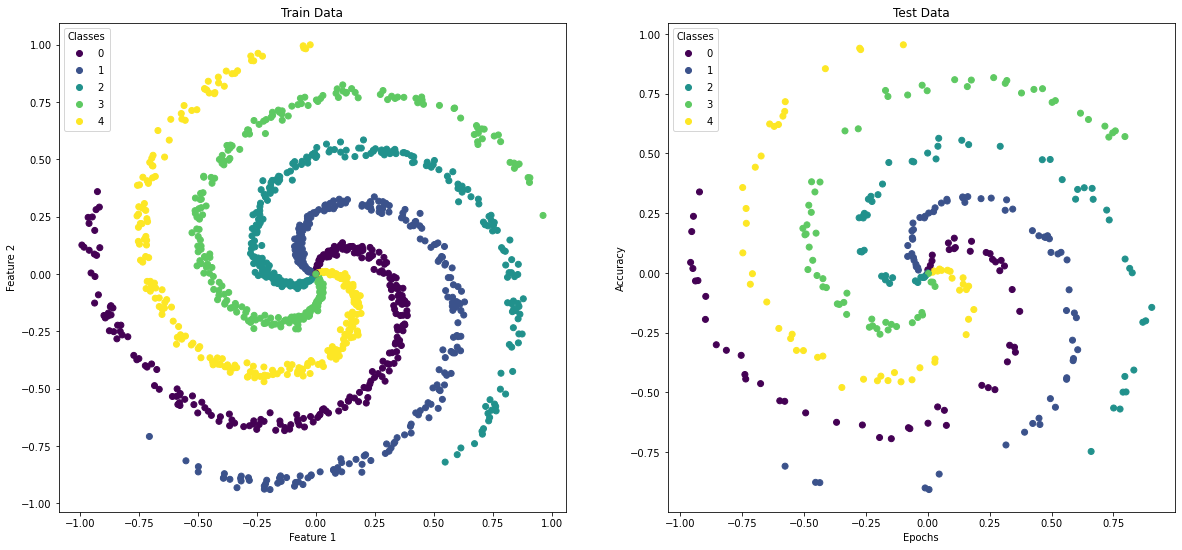

In [7]:
#Extract information and create a dataframe with it. The data type is setted to int for the labels and float for the parameters
df = pd.read_csv('./trainData.txt', sep= " ", names= ["label", "feature1", "feature2"], dtype={0:'int8',1:'float64',2:'float64'})
x_train = df['feature1']
y_train = df['feature2']
z_train = df['label']

df = pd.read_csv('./testData.txt', sep= " ", names= ["label", "feature1", "feature2"], dtype={0:'int8',1:'float64',2:'float64'})
x_test = df['feature1']
y_test = df['feature2']
z_test= df['label']

#Plot in the same level 

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,9))
sc1= ax1.scatter(x= x_train, y= y_train, c= z_train, cmap='viridis')
ax1.legend(*sc1.legend_elements(),loc="upper left", title="Classes")
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('Train Data')

sc2= ax2.scatter(x= x_test, y= y_test, c= z_test, cmap='viridis')
ax2.legend(*sc2.legend_elements(),loc="upper left", title="Classes")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Test Data')

In this part is represented the train and test data from the "trainData.txt" and "testData.txt" using matplotlib.

In [8]:
#Data analyzing
df = pd.read_csv('./trainData.txt', sep= " ", names= ["label", "feature1", "feature2"], dtype={0:'int8',1:'float64',2:'float64'})
label = df['label']
data = df.to_numpy()
print (df.head(10))
print (data.shape)
data = data.reshape(1200,3,1)
print (df['feature1'].min())
print (df['feature2'].min())
print (df['feature1'].max())
print (df['feature2'].max())

   label  feature1  feature2
0      2  0.243584  0.539536
1      0  0.029800  0.074531
2      4 -0.437585 -0.383632
3      2 -0.224602  0.407026
4      3  0.284853  0.800316
5      3 -0.142428  0.670662
6      3 -0.133061 -0.204701
7      1  0.125926  0.309836
8      1  0.617506 -0.075246
9      4 -0.752528  0.142420
(1200, 3)
-0.991967448973272
-0.9400215703956826
0.9633365007447032
0.9997144457080019


To analyze in more detail the data for each feature is printed the maximum and the minimum. I applied to the dataframe the name of the features and the types. The label are represented by integer.

In [9]:
class Data2D(Dataset):
    def __init__(self, dataframe, transform= None, target_transform= None):
        self.transform = transform
        self.target_transform = target_transform
        self.df = dataframe
        self.label = self.df['label']
        self.df = self.df.drop(['label'], axis='columns') 
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        data= []
        #Take the two features and transform into a tensor
        x= [self.df['feature1'][idx]]
        y= [self.df['feature2'][idx]]
        data.append(x)
        data.append(y)
        data = torch.Tensor(data)
        data = torch.squeeze(data)
        label = self.label.iloc[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label  

In [10]:
batch_size = 64
num_classes = 5

train= pd.read_csv('./trainData.txt', sep= " ", names= ["label", "feature1", "feature2"], dtype={0:'int8',1:'float64',2:'float64'})
dataset_train = Data2D(train)

# Set up the dataset
trainLoader = DataLoader(dataset_train, 
                        batch_size=batch_size, 
                        shuffle=True)

# Test get
dataiter = iter(trainLoader)
data, labels = dataiter.next()
print (data.size())
print (labels.size())       

torch.Size([64, 2])
torch.Size([64])


A personalized Dataset-class is created, that prepare the data for a size of (64,2) given from the train dataset. The batch size is setted to 64 and the features are temporary named x, y inside the class. A test of the DataLoader is provided, that return the size of batch label and tensor.  

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #Layers declared ready to use
        self.input = nn.Linear(in_features= 2,out_features= 784)
        self.lin1 = nn.Linear(784, 392)
        self.lin2 = nn.Linear(392,num_classes)
        self.norm = nn.BatchNorm1d(392)
        self.softmax= nn.Softmax(dim=1)


    def forward(self, x):
        #Defined network sequential structure
        x= self.input(x)
        x = F.leaky_relu(x)
        x= self.lin1(x)
        x= self.norm(x)
        x = F.relu(x)
        x= self.lin2(x)
        x= self.softmax(x)
        return x

net = NeuralNetwork()
print(net)

NeuralNetwork(
  (input): Linear(in_features=2, out_features=784, bias=True)
  (lin1): Linear(in_features=784, out_features=392, bias=True)
  (lin2): Linear(in_features=392, out_features=5, bias=True)
  (norm): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=1)
)


In [12]:
#Test the net
x = np.random.randn(64,2).astype('float32')
out = net(torch.from_numpy(x))
print('Output shape:', out.shape)

Output shape: torch.Size([64, 5])


The neural network is created. It is composed by several fully connected layers: Given an input of (64, 2) as batch and features we have an output of 784 from the first layer "self.input", so 784 neurons is used. After that "leaky_relu" activation function is used, this choice is derived from the thinking that we have in input negative values. After that the network goes through layer "lin2" that take the 784 inputs and from 392 neurons give 392 outputs to the normalizzation layer that speed up the training transforming negative values to a scale from 0 to 1. This particularity can improve also the work of the next activation function as "relu" that consider always positive values. The last layer provide to connect the activation function with 392 inputs to the the final stage of 5 outputs as many classes we have to classify. The softmax provide a scaling function 0 to 1 and all output give a sum wit result 1. This helps for the probability assignment through the prediction between classes.

In [13]:
import torch.optim as optim

#Defining learning rate, optimizer and the loss function
learningRate=0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)

loss_fn= nn.CrossEntropyLoss()

In [14]:
#Initilize parameters

nEpoch = 100

accuracy=np.zeros(nEpoch)

loss_values= []

for iEpoch in range(nEpoch):
    
    #Initilize parameters for each epochs
    estimatedLabels = np.empty((0,))
    trueLabels = np.empty((0,))
    
    running_loss = 0.0
    
    for data ,labels in trainLoader:
        
        y_pred = net(data)
   
        labels = labels.type(torch.LongTensor)

        #Compute loss
        loss = loss_fn(y_pred,labels)

        #Compute gradients
        net.zero_grad()

        loss.backward()
        
        #Update parameter
        optimizer.step()

        yhat= y_pred.argmax(1)
        estimatedLabels=np.append(estimatedLabels,yhat)
        trueLabels=np.append(trueLabels,labels)
        
        #Actual epoch-loss
        running_loss =+ loss.item() * batch_size
        
    loss_values.append(running_loss / len(df))
    accuracy[iEpoch]=np.mean(estimatedLabels==trueLabels) 

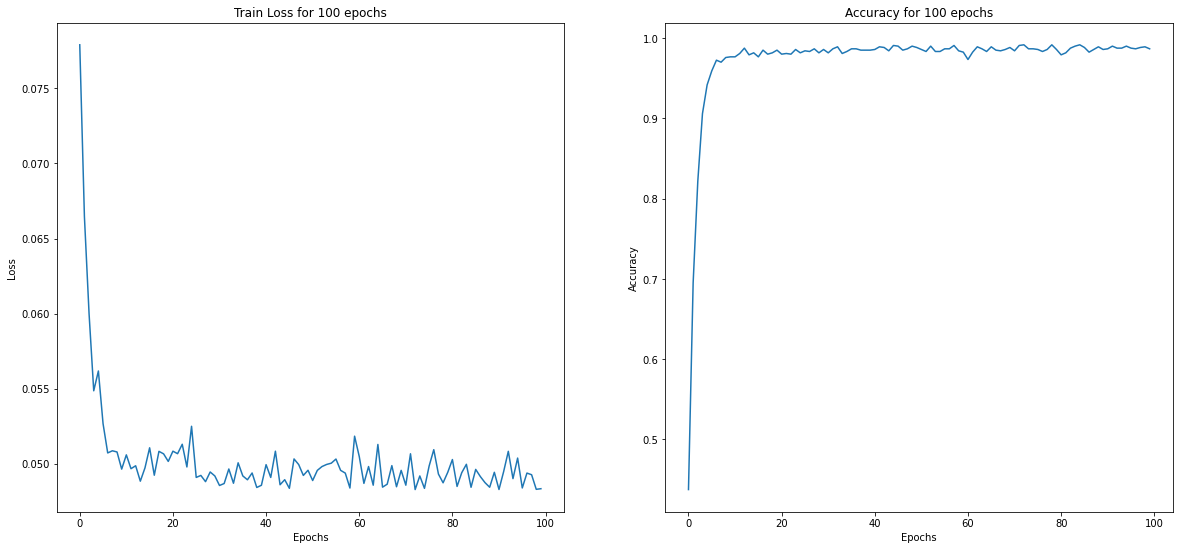

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,9))
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss for 100 epochs')
ax1.plot(loss_values)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy for 100 epochs')
ax2.plot(accuracy)

This is the part of training of the model. After setted the hyperparameter "learning rate" as 0.001 used from Adam optimizer and CrossEntropy for the loss calculation function (negative log likelihood loss). After initializing some variables and the "epoch" hyperparameter as 100, so the model will initialize parameters compute the gradients and update the paramters with the optimizzation function through the entire dataset, subdivided by mini-batch (64). The optimum value of the hyperparameters are taken after some test in the test data and looking at the loss chart where we can find an optimal value of "epoch" as subsequent training cycles is no longer needed. In this case we can select the "epoch" with a value around 20, because the loss of the next interations have no significant reduction and the curve is flattening (as the opposite of the accuracy). 

In [16]:
test= pd.read_csv('./testData.txt', sep= " ", names= ["label", "feature1", "feature2"], dtype={0:'int8',1:'float64',2:'float64'})
dataset_test = Data2D(test)

# Set up the dataset.
testLoader = DataLoader(dataset_test, 
                        batch_size=batch_size)

In [17]:
estimatedLabels=np.empty((0,))
trueLabels=np.empty((0,))

for data, labels in testLoader:
    y_pred=net(data)

    yhat= y_pred.argmax(1)
    estimatedLabels=np.append(estimatedLabels,yhat)
    trueLabels=np.append(trueLabels,labels)

#Mean of the all losses through all test-data
testAcc=np.mean(estimatedLabels==trueLabels) 
print(testAcc)

0.979933110367893


Text(0.5, 1.0, 'Prediction of regular spaced points in space')

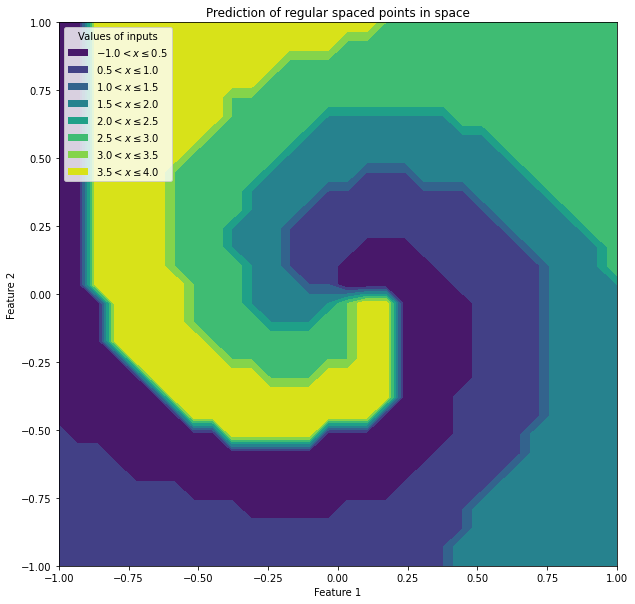

In [18]:
x,y=np.meshgrid(np.linspace(-1,1,30),np.linspace(-1,1,30))
xy=np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
z=net(torch.tensor(xy).float()).detach().numpy()
z=np.argmax(z,1).reshape(30,30)

fig, ax = plt.subplots(figsize=(10,10))
ct= ax.contourf(x,y,z)
ax.legend(*ct.legend_elements(),loc="upper left", title="Values of inputs")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Prediction of regular spaced points in space')

In this last part the network produce predictions over the test data. The function "argmax" provide to assign the probability in the network output to a predicted class. An array keep track of the accuracy through the entire dataset and printed after the prediction of the entire dataset. The last picture provide a visualizzation to how the network assign the class in the whole feature-space: This is made by producing a regular spatiated points of the 2D space as 30 points from -1 to 1, with applying a prediction for each sample. A final cosideration is that the model is optimal tuned because the train accuracy is very similat to the test accuracy with a very high value, no overfitting neither underfitting, low bias-low variance. 